In [ ]:
import csv
import json
from collections import defaultdict
import matplotlib.pyplot as plt
import string
import nltk
#nltk.download('stopwords')
from nltk.corpus import stopwords
from operator import itemgetter

def load_data():
    data = []
    label = ['image_id','unixtime','rawtime','title','total_votes','reddit_id','number_of_upvotes',\
    'subreddit','number_of_downvotes','localtime','score','number_of_comments','username',\
    'undefined1','undefined2', 'undefined3']

    with open('submissions.csv') as csvfile:
        csvReader = csv.reader(csvfile)
        for row in csvReader:
            if row[0] == '#image_id':
                continue
            d = {}
            for i,elem in enumerate(row):
                if label[i]=='total_votes' or label[i]=='number_of_upvotes' or label[i]=='number_of_downvotes' or label[i]=='score' or label[i]=='number_of_comments':
                    d[label[i]] = int(elem)
                else:
                    d[label[i]] = elem
                    #judge if element it is empty
            data.append(d)
    return data

data = load_data()
comments_sorted_data = sorted(data, key=itemgetter('number_of_comments'), reverse=True)
votes_sorted_data = sorted(data, key=itemgetter('total_votes'), reverse=True)

def title():
    wordCount = defaultdict(int)
    punctuation = set(string.punctuation)

    # word count in top 25000 titles with most comment numbers
    for d in comments_sorted_data[0:25000]:
        r = ''.join([c for c in d['title'].lower() if not c in punctuation])
        for w in r.split():
            wordCount[w] += 1

    # remove English stopwords
    for w in stopwords.words("english"):
        if w in wordCount:
            wordCount.pop(w)

    #print(len(wordCount))
    counts = [(wordCount[w], w) for w in wordCount]
    counts.sort()
    counts.reverse()

    # take top 1000 words to be targets
    words = [x[1] for x in counts[:1000]]
    wordId = dict(zip(words, range(len(words))))
    wordSet = set(words)

    title_comment_list = []
    for d in data:
        title_comment_num = 0
        for i,w in enumerate(words):
            if w in d['title']:
                title_comment_num = title_comment_num + (1000-i)
        title_comment_list.append(title_comment_num)

    return title_comment_list

#subreddit feature
def get_popular_subreddit():
    sub_post_num = defaultdict(int)
    sub_post_sorted = {}
    for d in data:
        sub = d.get('subreddit')
        sub_post_num[sub] += 1
    for key, value in sorted(sub_post_num.iteritems(), key=lambda (k,v): (v,k),reverse = True):
        sub_post_sorted[key] = value
        #sub_post_sorted.append((key,value))
        #print "%s: %s" % (key, value)
    return sub_post_sorted

sub_post_sorted = get_popular_subreddit()

def popular_subreddit():
    subreddit_list = []
    for d in data:
        sub = d.get('subreddit')
        subreddit_list.append(sub_post_sorted[sub])
    return subreddit_list

subreddit_list = popular_subreddit()

import re
def get_time_feature(d):
    # Create dummy variables based on exploratory analysis of this dataset and previous plots
    time_feature = []  #night(22-1),sleep time(2-7),morning(8-11),afternoon(12-17),[evening(18-21) is omitted]
                       #UTC+8,UTC+7,[UTC+0 is omitted]
    
    catchTime = re.compile("(.*)T(\d{2}):(\d{2}).*((-|\+)\d{2})")
    
    
    t = d['rawtime']
    m = catchTime.search(t)
    if m:
        d['hour'] = int(m.group(2))
        d['minute'] = int(m.group(3))
        if d['minute'] >= 30:
            d['time'] = (d['hour'] +1*0)%24
        else:
            d['time'] = d['hour']

        d['timezone'] = int(m.group(4))
        d['UTCtime'] = (d['time'] + d['timezone'])%24
            
    if d['UTCtime'] >= 22 or d['UTCtime'] <= 1:
        time_feature.append(1)
    else:
        time_feature.append(0)
        
    if d['UTCtime'] >= 2 and d['UTCtime'] <= 7:
        time_feature.append(1)
    else:
        time_feature.append(0)
        
    if d['UTCtime'] >= 8 and d['UTCtime'] <= 11:
        time_feature.append(1)
    else:
        time_feature.append(0)
    
    if d['UTCtime'] >= 12 and d['UTCtime'] <= 17:
        time_feature.append(1)
    else:
        time_feature.append(0)
    
    if d['timezone'] == -8:
        time_feature.append(1)
    else:
        time_feature.append(0)
    
    if d['timezone'] == -7:
        time_feature.append(1)
    else:
        time_feature.append(0)
    
    return time_feature

import datetime
def get_date_feature(d):
    date_feature = [0]*17 #month(1-11),weekday(Monday-Saturday)
    t = d['unixtime']
    this_day = datetime.datetime.utcfromtimestamp(int(t))
    if this_day.month != 12 and this_day.weekday() != 6:
        date_feature[this_day.month-1] = 1
        date_feature[this_day.weekday()+11] = 1
    return date_feature


raw_time_list = []
date_list = []
for d in data:
    raw_time_list.append(get_time_feature(d))
    date_list.append(get_date_feature(d))

# submission time feature
def submission():
    ID = '-1'
    submission_list = []

    # original data is sorted in image_ID, count submission times before current submission
    for d in data:
        if d['image_id'] == ID:
            count = count + 1
            d['submission_time'] = count
        else:
            count = 0
            ID = d['image_id']
            d['submission_time'] = count

    for d in data:
        submission_list.append(d['submission_time'])

    return submission_list

# username feature
def username():
    with open('all_user_profile.json', 'r') as f:
        all_user_profile = json.load(f)
    user_comment_list = []
    user_comment_dict = {}
    for user in all_user_profile:
        
        user_comment_dict[user.get('username')] = user.get('avg_comments')

    for d in data:
        if d['username']=='':
            user_comment_list.append(d['number_of_comments'])
        elif d['username'] in user_comment_dict:
            user_comment_list.append(user_comment_dict[d['username']])
    return user_comment_list

#subreddit feature
def subreddit():
    with open('all_subreddit_profile.json', 'r') as f:
        all_subreddit_profile = json.load(f)
    #post_list = []
    sub_comment_list = []
    sub_comment_dict = {}
    sub_votes_list = []
    sub_votes_dict = {}
    for sub in all_subreddit_profile:
        # post_list.append(sub.get('num_of_post'))
        #sub_votes_dict[sub.get('subreddit')] = sub.get('avg_votes')
        sub_comment_dict[sub.get('subreddit')] = sub.get('avg_comments')

    for d in data:
        if d['subreddit']=='':
            sub_comment_list.append(d['number_of_comments'])
        elif d['subreddit'] in sub_comment_dict:
            sub_comment_list.append(sub_comment_dict[d['subreddit']])
        #if d['subreddit'] in sub_votes_dict:
            #sub_votes_list.append(sub_votes_dict[d['subreddit']])

    return sub_comment_list

with open('kmean_d.json', 'r') as f:
        Kmeans_title = json.load(f)

with open('title_len_list.json', 'r') as f:
        title_len_list = json.load(f)

# with open('LSA_m.json', 'r') as f:
#         LSA_m = json.load(f)
#Tuoying's part is missing :(

#data[1999]

from collections import Counter
subreddits = Counter()
for d in data:
    subreddits[d['subreddit']] += 1
succeeded = []
popular_communities = [i[0] for i in subreddits.most_common(10)]
successTime = {}
idx = 0
scores = Counter()
for d in data:
    if d['number_of_comments']*0.2 + d['total_votes']*0.8 > 36 and d['subreddit'] in popular_communities:
        #Already succeeded in popular communities
        if d['image_id'] not in successTime:
            successTime[d['image_id']] = idx
    idx += 1
#     scores[d['score']] += 1  
    
# #scores.most_common(10)
idx = 0
for d in data:
    if d['image_id'] not in successTime or idx <= successTime[d['image_id']]:
        #haven't succeed yet
        succeeded.append(0)
    else:
        succeeded.append(1)
    idx += 1
    

In [138]:
succeeded_in_sub = []
succeeded_subs = {} #given image_id, which subreddits did it succeed

for d in data:
    if d['image_id'] in succeeded_subs and d['subreddit'] in succeeded_subs[d['image_id']]:
        succeeded_in_sub.append(1)
    else:
        succeeded_in_sub.append(0)
    
    if d['number_of_comments']*0.2 + d['total_votes']*0.8 > 200:
        #succeeded
        if d['image_id'] not in succeeded_subs:
            succeeded_subs[d['image_id']] = set()
        succeeded_subs[d['image_id']].add(d['subreddit'])

In [139]:
submission_list = submission()

comment_feature_list = []
comment_label_list = []
for i in range(len(data)):
    large = 0
    tmp_list = [submission_list[i],title_len_list[i],raw_time_list[i][0],raw_time_list[i][1],raw_time_list[i][2],raw_time_list[i][3],raw_time_list[i][4],raw_time_list[i][5]]

    tmp_list.extend(date_list[i])
    tmp_list.append(subreddit_list[i])
    tmp_list.append(succeeded[i])
    tmp_list.append(succeeded_in_sub[i])
    comment_feature_list.append(tmp_list)
    
    if data[i]['number_of_comments']*0.2 + data[i]['total_votes']*0.8  > 36: large = 1 #votes and comment label 
    comment_label_list.append(large)

print "feature[title_keyword,submission_time,username,subreddit]:",len(comment_feature_list[0])
print "label[total_votes]:",comment_label_list[0]

feature[title_keyword,submission_time,username,subreddit]: 28
label[total_votes]: 1


In [140]:
comment_feature_list[0]

[0,
 4,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 55281,
 0,
 0]

In [141]:
import os
import time
from sklearn import metrics
import numpy as np
import pickle

import sys

import sklearn
print('The scikit-learn version is {}.'.format(sklearn.__version__))

from sklearn.cross_validation import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

X_train, X_test, y_train, y_test = train_test_split(comment_feature_list, comment_label_list, random_state=4)

X_train[0:10]

The scikit-learn version is 0.19.1.


[[5,
  8,
  0,
  0,
  0,
  1,
  0,
  1,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  55281,
  1,
  1],
 [16,
  7,
  1,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  5608,
  1,
  1],
 [1,
  6,
  0,
  1,
  0,
  0,
  0,
  1,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  12193,
  1,
  0],
 [3,
  8,
  0,
  1,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  55281,
  1,
  0],
 [0,
  9,
  0,
  0,
  1,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  3366,
  0,
  0],
 [12,
  3,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  12193,
  1,
  1],
 [4,
  1,
  1,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  552

In [142]:
from sklearn import preprocessing
scaler = preprocessing.StandardScaler()
min_max_scaler = preprocessing.MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

len(X_train)

len(X_test)

X_train[0:10]

array([[-0.25810155,  0.31366411, -0.45460294, -0.63410438, -0.44275513,
         1.72046876, -0.18079946,  0.71826926, -0.21337249, -0.16718038,
         5.21366805, -0.21205259, -0.21568545, -0.23782342, -0.30874974,
        -0.33838666, -0.4420712 , -0.40756406, -0.28530026, -0.40658849,
        -0.40652117, -0.40581404, -0.40927731,  2.60074379, -0.37074249,
         1.12269297,  0.51331958,  1.07868928],
       [ 0.56022825,  0.09901414,  2.19972183, -0.63410438, -0.44275513,
        -0.58123694, -0.18079946,  0.71826926, -0.21337249, -0.16718038,
        -0.19180354, -0.21205259, -0.21568545, -0.23782342, -0.30874974,
        -0.33838666,  2.26207904, -0.40756406, -0.28530026, -0.40658849,
        -0.40652117, -0.40581404,  2.44333118, -0.38450539, -0.37074249,
        -1.14483675,  0.51331958,  1.07868928],
       [-0.55567602, -0.11563583, -0.45460294,  1.57702742, -0.44275513,
        -0.58123694, -0.18079946,  0.71826926, -0.21337249, -0.16718038,
         5.21366805, -0.2120

## Logistic Regression Classifier

In [143]:
from sklearn.cross_validation import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.metrics.scorer import make_scorer
from sklearn.metrics import recall_score

### Validation

In [144]:
# Logistic Regression Classifier
from sklearn.linear_model import LogisticRegression
LR = LogisticRegression(penalty='l2', class_weight = 'balanced') # balanced：让类库自己计算类型权重
LR_scores = cross_val_score(LR, X_train, y_train, cv=10, scoring='accuracy')
print("Accuracy: %0.4f (+/- %0.4f)" % (LR_scores.mean(), LR_scores.std() * 2))

scoring = {'prec_macro': 'precision_macro','rec_micro': make_scorer(recall_score, average='macro')}
all_scores = cross_validate(LR, X_train, y_train, scoring=scoring,cv=10, return_train_score=True)
score = all_scores['test_rec_micro'] 
print("Recall: %0.4f (+/- %0.4f)" % (score.mean(), score.std() * 2))
score = all_scores['test_prec_macro'] 
print("Precision: %0.4f (+/- %0.4f)" % (score.mean(), score.std() * 2))

Accuracy: 0.6687 (+/- 0.0121)
Recall: 0.6686 (+/- 0.0121)
Precision: 0.6688 (+/- 0.0121)


## test set

In [145]:
LR.fit(X_train,y_train)
theta = LR.coef_
predict = LR.predict(X_test)
precision = metrics.precision_score(y_test, predict)
recall = metrics.recall_score(y_test, predict)
print ('precision: %.2f%%, recall: %.2f%%' % (100 * precision, 100 * recall))
accuracy = metrics.accuracy_score(y_test, predict)
print ('accuracy: %.2f%%' % (100 * accuracy) )
print("Theta",theta)

precision: 66.66%, recall: 69.04%
accuracy: 67.47%
('Theta', array([[-0.3366103 , -0.02542098,  0.04494   ,  0.00407469,  0.02336471,
         0.01814905, -0.01906309,  0.37406267,  0.08326419,  0.12162135,
         0.14154005,  0.09865107,  0.09033634,  0.05236045, -0.08474114,
        -0.1314046 , -0.18346188, -0.14551801,  0.00487096, -0.03288222,
        -0.05171157, -0.04012235, -0.05949376, -0.03799053,  0.0283868 ,
        -0.31000271, -0.17097606,  0.07547683]]))


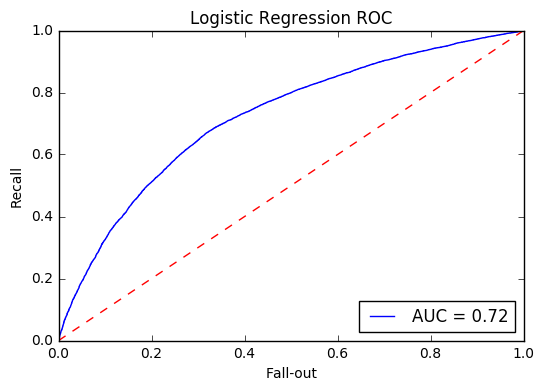

In [146]:
from sklearn.metrics import roc_curve, auc  
predictions = LR.predict_proba(X_test)  
false_positive_rate, recall, thresholds = roc_curve(y_test, predictions[:, 1])  
roc_auc = auc(false_positive_rate, recall)  
plt.title('Logistic Regression ROC')  
plt.plot(false_positive_rate, recall, 'b', label='AUC = %0.2f' % roc_auc)  
plt.legend(loc='lower right')  
plt.plot([0, 1], [0, 1], 'r--')  
plt.xlim([0.0, 1.0])  
plt.ylim([0.0, 1.0])  
plt.ylabel('Recall')  
plt.xlabel('Fall-out') 
plt.savefig('Logistic Regression ROC.png',dpi=600)
plt.show()  

## Decision Tree Classifier

In [147]:
### Validation

In [148]:
from sklearn import tree
# max_depth = 4, 限制树的最大深度4,其实特征少的时候不用限制这个深度，但不知道为什么这里限制了之后准确率提高
DT = tree.DecisionTreeClassifier(class_weight = 'balanced',max_depth = 4) 
DT_scores = cross_val_score(DT, X_train, y_train, cv=10, scoring='accuracy')
print("Accuracy: %0.4f (+/- %0.4f)" % (DT_scores.mean(), DT_scores.std() * 2))

scoring = {'prec_macro': 'precision_macro','rec_micro': make_scorer(recall_score, average='macro')}
all_scores = cross_validate(DT, X_train, y_train, scoring=scoring,cv=10, return_train_score=True)
score = all_scores['test_rec_micro'] 
print("Recall: %0.4f (+/- %0.4f)" % (score.mean(), score.std() * 2))
score = all_scores['test_prec_macro'] 
print("Precision: %0.4f (+/- %0.4f)" % (score.mean(), score.std() * 2))

Accuracy: 0.6742 (+/- 0.0101)
Recall: 0.6740 (+/- 0.0101)
Precision: 0.6745 (+/- 0.0102)


In [149]:
### TEST SET

In [150]:
DT.fit(X_train,y_train)
predict = DT.predict(X_test)
precision = metrics.precision_score(y_test, predict)
recall = metrics.recall_score(y_test, predict)
print ('precision: %.2f%%, recall: %.2f%%' % (100 * precision, 100 * recall))
accuracy = metrics.accuracy_score(y_test, predict)
print ('accuracy: %.2f%%' % (100 * accuracy) )

precision: 66.38%, recall: 70.41%
accuracy: 67.58%


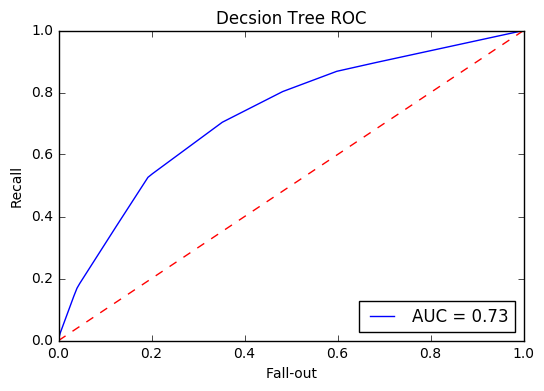

In [151]:
from sklearn.metrics import roc_curve, auc  
predictions = DT.predict_proba(X_test)  
false_positive_rate, recall, thresholds = roc_curve(y_test, predictions[:, 1])  
roc_auc = auc(false_positive_rate, recall)  
plt.title('Decsion Tree ROC')  
plt.plot(false_positive_rate, recall, 'b', label='AUC = %0.2f' % roc_auc)  
plt.legend(loc='lower right')  
plt.plot([0, 1], [0, 1], 'r--')  
plt.xlim([0.0, 1.0])  
plt.ylim([0.0, 1.0])  
plt.ylabel('Recall')  
plt.xlabel('Fall-out')
plt.savefig('Decsion Tree ROC.png',dpi=600)
plt.show()  

##AB(AdaBoost) Classifier

In [152]:
from sklearn.ensemble import AdaBoostClassifier
# 一般来说n_estimators太小，容易欠拟合，n_estimators太大，又容易过拟合，一般选择一个适中的数值。默认是50
#对于同样的训练集拟合效果，较小的νν意味着我们需要更多的弱学习器的迭代次数。通常我们用步长和迭代最大次数一起来决定算法的拟合效果。
#所以这两个参数n_estimators和learning_rate要一起调参。一般来说，可以从一个小一点的νν开始调参，默认是1
Ada= AdaBoostClassifier(n_estimators=200,learning_rate=0.8)
Ada_scores = cross_val_score(Ada, X_train, y_train, cv=10, scoring='accuracy')
print("Accuracy: %0.4f (+/- %0.4f)" % (DT_scores.mean(), DT_scores.std() * 2))

scoring = {'prec_macro': 'precision_macro','rec_micro': make_scorer(recall_score, average='macro')}
all_scores = cross_validate(Ada, X_train, y_train, scoring=scoring,cv=10, return_train_score=True)
score = all_scores['test_rec_micro'] 
print("Recall: %0.4f (+/- %0.4f)" % (score.mean(), score.std() * 2))
score = all_scores['test_prec_macro'] 
print("Precision: %0.4f (+/- %0.4f)" % (score.mean(), score.std() * 2))

Accuracy: 0.6742 (+/- 0.0101)
Recall: 0.7113 (+/- 0.0119)
Precision: 0.7114 (+/- 0.0119)


###TEST SET

In [153]:
Ada.fit(X_train,y_train)
predict = Ada.predict(X_test)
precision = metrics.precision_score(y_test, predict)
recall = metrics.recall_score(y_test, predict)
print ('precision: %.2f%%, recall: %.2f%%' % (100 * precision, 100 * recall))
accuracy = metrics.accuracy_score(y_test, predict)
print ('accuracy: %.2f%%' % (100 * accuracy) )

precision: 71.77%, recall: 70.52%
accuracy: 71.58%


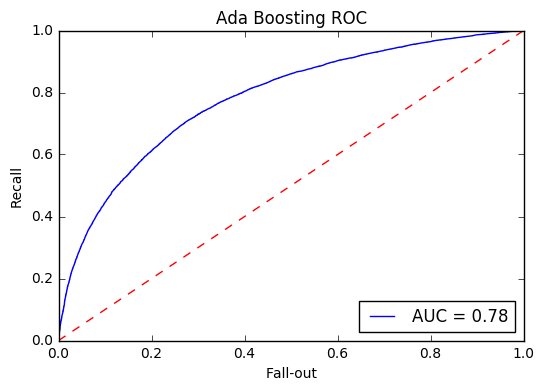

In [154]:
from sklearn.metrics import roc_curve, auc  
predictions = Ada.predict_proba(X_test)  
false_positive_rate, recall, thresholds = roc_curve(y_test, predictions[:, 1])  
roc_auc = auc(false_positive_rate, recall)  
plt.title('Ada Boosting ROC')  
plt.plot(false_positive_rate, recall, 'b', label='AUC = %0.2f' % roc_auc)  
plt.legend(loc='lower right')  
plt.plot([0, 1], [0, 1], 'r--')  
plt.xlim([0.0, 1.0])  
plt.ylim([0.0, 1.0])  
plt.ylabel('Recall')  
plt.xlabel('Fall-out') 
plt.savefig('Ada Boosting ROC.png',dpi=600)
plt.show() 